# A Network of Lookup Tables

In [4]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
import pickle
import pandas as pd
from sklearn.metrics import accuracy_score
import time

%matplotlib inline

## Example 2

A network of k = 2 layers.
The first layer has 2 luts.
The second layer has 1 lut.

In [2]:
train_set = [([0,0,0],0),([0,0,0],1),([0,0,0],1),([0,0,1],1),([1,0,0],0),([1,1,0],0),([1,1,0],1)]
X_train = np.array([[0,0,0],[0,0,0],[0,0,0],[0,0,1],[1,0,0],[1,1,0],[1,1,0]])
y_train = np.array([0,1,1,1,0,0,1])

In [3]:
class LUT:
    def __init__(self, inputs, indexes_0, indexes_1, k , index = []):
        # build lut
        self.k = k
        if (index == []):
            self.index = np.sort(np.random.choice(len(inputs[0]),k,replace = False))
        else:
            self.index = index
        self.inv = np.arange(k-1,-1,-1)
        self.output = np.zeros((2**k), int)
        self.count_0 = np.zeros((2**k), int)
        self.count_1 = np.zeros((2**k), int)
        self.count(inputs[:,self.index], indexes_0,indexes_1)
        
    def count(self, subset, indexes_0, indexes_1):
        zeros = Counter(np.sort(self.get_index_vec_to_dec(subset[indexes_0])))
        ones =  Counter(np.sort(self.get_index_vec_to_dec(subset[indexes_1])))
        for key in zeros.keys():
            self.count_0[key] = zeros[key]
        for key in ones.keys():
            self.count_1[key] = ones[key]
        # compute lut
        self.output[self.count_0 > self.count_1] = 0
        self.output[self.count_0 < self.count_1] = 1
        # picked uniformly at random
        self.output[self.count_0 == self.count_1] = np.random.choice([0,1], len(self.output[self.count_0 == self.count_1]))
        
    def get_index_vec_to_dec(self, X , axis = 1):
        dec_index = np.sum(X * np.power(2*np.ones(self.k,int),self.inv),axis= axis)
        return dec_index
    
    def get_index_dec_to_vec(self, dec):
        return "{0:b}".format(dec).zfill(self.k)
    
    def look(self, X):
        # X is a numpy array
        X = np.array(X)
        return self.output[self.get_index_vec_to_dec(X[self.index], 0)]
    
    def look_array(self, dataset):
        subdataset = dataset[:,self.index]
        return self.output[self.get_index_vec_to_dec(subdataset)]
        
    def score(self, labels, dataset):
        predicted = self.look_array(dataset)
        return accuracy_score(labels,predicted)
    
    def show(self):
        print("Look up table")
        print("Index = {}".format(self.index))
        print("  p    |  y0 |  y1 |  f   |")
        for i in range(len(self.output)):
            if (self.count_0[i] == self.count_1[i]):
                f = "{}*".format(self.output[i])
            else:
                f = "{} ".format(self.output[i])
            print("  {}   |  {}  |  {}  |  {}  |".format(self.get_index_dec_to_vec(i), self.count_0[i], self.count_1[i], f))
            
    def clean(self):
        self.count_0 = None
        self.count_1 = None

In [4]:
#index = np.sort(np.random.choice(len(train_set[0][0]),k,replace = False))
k = 2
index = [0,1]
lut = LUT(X_train,np.where(y_train == 0), np.where(y_train == 1), 2, index)
lut.show()
print("predict [0,0,0] : {}".format(lut.look(np.array([0,0,0]))))
print("accuracy : {}".format(lut.score(y_train, X_train)))

Look up table
Index = [0, 1]
  p    |  y0 |  y1 |  f   |
  00   |  1  |  3  |  1   |
  01   |  0  |  0  |  1*  |
  10   |  1  |  0  |  0   |
  11   |  1  |  1  |  0*  |
predict [0,0,0] : 1
accuracy : 0.7142857142857143


In [5]:
n_luts = [2, 1] # number of luts per layer
k = 2 # sampling input

# make a Network of look up table
layers = []

indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)
outputs = np.zeros((len(X_train),n_luts[0]),int)

start = time.time()

# first layer
print(" ==== first layer === \n")
layer = []
for i in range(n_luts[0]):
    # build lut
    lut = LUT(X_train, indexes_0, indexes_1, k)
    lut.show()
    outputs[:,i] = lut.look_array(X_train)
    lut.clean()
    layer.append(lut)
layers.append(layer)

# second layer
print("\n ==== second layer === \n")
layer = []
inputs = outputs
outputs = np.zeros((len(X_train),n_luts[1]),int)
for i in range(n_luts[1]):
    lut = LUT(inputs, indexes_0, indexes_1, k)
    lut.show()
    outputs[:,i] = lut.look_array(inputs)
    lut.clean()
    layer.append(lut)
layers.append(layer) 

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

 ==== first layer === 

Look up table
Index = [0 1]
  p    |  y0 |  y1 |  f   |
  00   |  1  |  3  |  1   |
  01   |  0  |  0  |  0*  |
  10   |  1  |  0  |  0   |
  11   |  1  |  1  |  1*  |
Look up table
Index = [0 2]
  p    |  y0 |  y1 |  f   |
  00   |  1  |  2  |  1   |
  01   |  0  |  1  |  1   |
  10   |  2  |  1  |  0   |
  11   |  0  |  0  |  0*  |

 ==== second layer === 

Look up table
Index = [0 1]
  p    |  y0 |  y1 |  f   |
  00   |  1  |  0  |  0   |
  01   |  0  |  0  |  1*  |
  10   |  1  |  1  |  0*  |
  11   |  1  |  3  |  1   |
Time spent : 0.02s


## Experiment 1

A Network with 5 hidden layers of 1024 luts and 1 lut in the output layer. k = 9.

### Load MNIST

In [6]:
"""
def loadMNIST(prefix, folder):
    intType = np.dtype( 'int32' ).newbyteorder( '>' )
    nMetaDataBytes = 4 * intType.itemsize

    data = np.fromfile( folder + "/" + prefix + '-images.idx3-ubyte', dtype = 'ubyte' )
    magicBytes, nImages, width, height = np.frombuffer( data[:nMetaDataBytes].tobytes(), intType )
    data = data[nMetaDataBytes:].astype( dtype = 'float32' ).reshape( [ nImages, width, height ] )

    labels = np.fromfile( folder + "/" + prefix + '-labels.idx1-ubyte',
                          dtype = 'ubyte' )[2 * intType.itemsize:]

    return data, labels

trainingImages, trainingLabels = loadMNIST( "train", "./data/mnist" )
testImages, testLabels = loadMNIST( "t10k", "./data/mnist" )

from ipywidgets import FloatProgress
from IPython.display import display

X_train = np.zeros((60000,784), int)
y_train = np.zeros((60000),int)
threshold=0.3 * 255
f = FloatProgress(min=0, max=trainingImages.shape[0])
display(f)
for i in range(trainingImages.shape[0]): 
    f.value+=1
    X_train[i,:]= 1.0*(trainingImages[i].reshape(784)>threshold)
y_train[trainingLabels>4] = 1
print(X_train.shape)

X_test = np.zeros((10000,784), int)
y_test = np.zeros((10000),int)
threshold=0.3 * 255
f = FloatProgress(min=0, max=testImages.shape[0])
display(f)
for i in range(testImages.shape[0]): 
    f.value+=1
    X_test[i,:]= 1.0*(testImages[i].reshape(784)>threshold)
y_test[testLabels>4] = 1
print(X_test.shape)

with open('./data/mnist/mnist_X_train.p', 'wb') as f:
    pickle.dump(X_train, f)
with open('./data/mnist/mnist_y_train.p', 'wb') as f:
    pickle.dump(y_train, f)
with open('./data/mnist/mnist_X_test.p', 'wb') as f:
    pickle.dump(X_test, f)
with open('./data/mnist/mnist_y_test.p', 'wb') as f:
    pickle.dump(y_test, f)
"""

'\ndef loadMNIST(prefix, folder):\n    intType = np.dtype( \'int32\' ).newbyteorder( \'>\' )\n    nMetaDataBytes = 4 * intType.itemsize\n\n    data = np.fromfile( folder + "/" + prefix + \'-images.idx3-ubyte\', dtype = \'ubyte\' )\n    magicBytes, nImages, width, height = np.frombuffer( data[:nMetaDataBytes].tobytes(), intType )\n    data = data[nMetaDataBytes:].astype( dtype = \'float32\' ).reshape( [ nImages, width, height ] )\n\n    labels = np.fromfile( folder + "/" + prefix + \'-labels.idx1-ubyte\',\n                          dtype = \'ubyte\' )[2 * intType.itemsize:]\n\n    return data, labels\n\ntrainingImages, trainingLabels = loadMNIST( "train", "./data/mnist" )\ntestImages, testLabels = loadMNIST( "t10k", "./data/mnist" )\n\nfrom ipywidgets import FloatProgress\nfrom IPython.display import display\n\nX_train = np.zeros((60000,784), int)\ny_train = np.zeros((60000),int)\nthreshold=0.3 * 255\nf = FloatProgress(min=0, max=trainingImages.shape[0])\ndisplay(f)\nfor i in range(trai

In [2]:
with open('./data/mnist/mnist_X_train.p', 'rb') as f:
    X_train = pickle.load(f)
with open('./data/mnist/mnist_y_train.p', 'rb') as f:
    y_train = pickle.load(f)
with open('./data/mnist/mnist_X_test.p', 'rb') as f:
    X_test = pickle.load(f)
with open('./data/mnist/mnist_y_test.p', 'rb') as f:
    y_test = pickle.load(f)

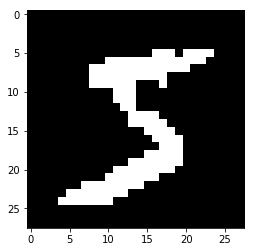

In [8]:
plt.imshow(X_train[0].reshape(28,28) , matplotlib.pyplot.cm.gray)

### Build Network

In [9]:
from tqdm import tqdm

n_luts = [784, 1024,1024,1024,1024,1024,1] # number of luts per layer
k = 8 # sampling input
layers = []

inputs = np.zeros((len(y_train),8),int)
indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []

start = time.time()

# input layer
l = 0
print("layer {} nb luts : {}".format(l, n_luts[l]))
layer = []
accuracy = []
inputs = X_train
outputs = np.zeros((len(y_train),n_luts[l]),int)
for i in tqdm(range(n_luts[0])):
    # build lut
    lut = LUT(inputs, indexes_0, indexes_1, k)
    outputs[:,i] = lut.look_array(inputs)
    layer.append(lut)
    accuracy.append(accuracy_score(y_train, outputs[:,i]))
layers.append(layer)
train_accuracy.append(accuracy)

# 5 hidden layers + 1 output layer
for l in range(1,7):
    print("layer {} nb luts : {}".format(l, n_luts[l]))
    layer = []
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(y_train),n_luts[l]),int)
    for i in tqdm(range(n_luts[l])):
        lut = LUT(inputs, indexes_0, indexes_1, k)
        outputs[:,i] = lut.look_array(inputs)
        layer.append(lut)
        accuracy.append(accuracy_score(y_train, outputs[:,i]))
    layers.append(layer)
    train_accuracy.append(accuracy)
    
end = time.time() - start
print("Time spent : {:.2f}s".format(end))

layer 0 nb luts : 784


100%|████████████████████████████████████████████████████████████████████████████████| 784/784 [01:26<00:00, 10.29it/s]


layer 1 nb luts : 1024


100%|██████████████████████████████████████████████████████████████████████████████| 1024/1024 [01:51<00:00,  6.07it/s]


layer 2 nb luts : 1024


100%|██████████████████████████████████████████████████████████████████████████████| 1024/1024 [01:50<00:00, 10.96it/s]


layer 3 nb luts : 1024


100%|██████████████████████████████████████████████████████████████████████████████| 1024/1024 [01:44<00:00,  9.85it/s]


layer 4 nb luts : 1024


100%|██████████████████████████████████████████████████████████████████████████████| 1024/1024 [01:37<00:00, 10.69it/s]


layer 5 nb luts : 1024


100%|██████████████████████████████████████████████████████████████████████████████| 1024/1024 [01:44<00:00,  5.15it/s]


layer 6 nb luts : 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s]


Time spent : 615.35s


In [10]:
print("Experiment 1 : Training accuracy\n")
df = pd.DataFrame(train_accuracy).transpose()
df.describe()

Experiment 1 : Training accuracy



,0,1,2,3,4,5,6
count,784.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1.000000
mean,0.610645,0.754713,0.842633,0.877109,0.891229,0.899225,0.904383
std,0.044402,0.019719,0.006909,0.003001,0.001228,0.000564,NaN
min,0.511017,0.670267,0.819883,0.866267,0.887483,0.896983,0.904383
25%,0.580608,0.742179,0.837696,0.875142,0.890333,0.898850,0.904383
50%,0.608142,0.755833,0.842892,0.877175,0.891283,0.899233,0.904383
75%,0.639158,0.768221,0.847467,0.879237,0.892117,0.899600,0.904383
max,0.738200,0.805000,0.862433,0.886533,0.894917,0.901383,0.904383


In [11]:
# Compute test accuracy

# input layer
k = 8

test_accuracy = []

start = time.time()

inputs = X_test
outputs = np.zeros((len(X_test),len(layers[0])),int)
accuracy = []
for i in tqdm(range(len(layers[0]))):
    score = layers[0][i].score(y_test, inputs)
    outputs[:,i] = layers[0][i].look_array(inputs)
    accuracy.append(score)
test_accuracy.append(accuracy)
    
for layer in layers[1:]:
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(X_test),len(layer)),int)
    for i in tqdm(range(len(layer))):
        score = layer[i].score(y_test, inputs)
        outputs[:,i] = layer[i].look_array(inputs)
        accuracy.append(score)
    test_accuracy.append(accuracy)

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 91.13it/s]


Time spent : 56.46s


In [12]:
print("Experiment 1 : Test accuracy\n")
df = pd.DataFrame(test_accuracy).transpose()
df.describe()

Experiment 1 : Test accuracy



,0,1,2,3,4,5,6
count,784.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1.0000
mean,0.613493,0.756990,0.840777,0.870485,0.879074,0.881552,0.8832
std,0.047596,0.020737,0.007555,0.003833,0.002099,0.001435,NaN
min,0.508400,0.673600,0.812500,0.858600,0.873000,0.876900,0.8832
25%,0.580550,0.744375,0.835800,0.868000,0.877600,0.880600,0.8832
50%,0.610550,0.758800,0.840700,0.870300,0.879100,0.881600,0.8832
75%,0.644775,0.771125,0.845825,0.873100,0.880500,0.882500,0.8832
max,0.744000,0.810100,0.861800,0.881100,0.885600,0.886400,0.8832


## Experiment 2

k = 2,4,6,8,10,12,14,16

In [13]:
n_luts = [784, 1024,1024,1024,1024,1024,1] # number of luts per layer
k_list = [2,4,6,8,10,12,14,16] # sampling input

nn_list = []

inputs = np.zeros((len(y_train),8),int)
indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []

start = time.time()

for k in k_list:
    layers = []
    print(" Memorization k = {}".format(k))
    interm = time.time()
    # input layer
    l = 0
    layer = []
    inputs = X_train
    outputs = np.zeros((len(y_train),n_luts[l]),int)
    for i in tqdm(range(n_luts[0])):
        # build lut
        lut = LUT(inputs, indexes_0, indexes_1, k)
        outputs[:,i] = lut.look_array(inputs)
        layer.append(lut)
    layers.append(layer)

    # 5 hidden layers + 1 output layer
    for l in range(1,7):
        layer = []
        inputs = outputs
        outputs = np.zeros((len(y_train),n_luts[l]),int)
        for i in tqdm(range(n_luts[l])):
            lut = LUT(inputs, indexes_0, indexes_1, k)
            outputs[:,i] = lut.look_array(inputs)
            layer.append(lut)
        layers.append(layer)
    print("accuracy :{}".format(accuracy_score(y_train, outputs)))
    train_accuracy.append(accuracy_score(y_train, outputs))
    
    end = time.time() - interm
    print("Time spent :{:.2f}s".format(end))
    nn_list.append(layers)
    
end = time.time() - start
print("Total Time spent : {:.2f}s".format(end))

 Memorization k = 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.23it/s]


accuracy :0.7228333333333333
Time spent :319.49s
 Memorization k = 4


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.67it/s]


accuracy :0.8290833333333333
Time spent :382.50s
 Memorization k = 6


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.93it/s]


accuracy :0.8602833333333333
Time spent :422.10s
 Memorization k = 8


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.74it/s]


accuracy :0.90265
Time spent :446.01s
 Memorization k = 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.77it/s]


accuracy :0.9546833333333333
Time spent :463.16s
 Memorization k = 12


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.81it/s]


accuracy :0.9909
Time spent :563.80s
 Memorization k = 14


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.84it/s]


accuracy :0.9994333333333333
Time spent :593.58s
 Memorization k = 16


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.02it/s]


accuracy :0.9999833333333333
Time spent :755.17s
Total Time spent : 3946.30s


In [17]:
len(nn_list[0][0])

784

In [25]:
# Compute test accuracy

# input layer
start = time.time()

test_accuracy = []

for n in range(len(nn_list)):
    
    layers = nn_list[n]
    k = k_list[n]
    interm = time.time()
    
    inputs = X_test
    outputs = np.zeros((len(X_test),len(layers[0])),int)
    for i in tqdm(range(len(layers[0]))):
        outputs[:,i] = layers[0][i].look_array(inputs)
        accuracy.append(score)

    for layer in layers[1:]:
        inputs = outputs
        outputs = np.zeros((len(X_test),len(layer)),int)
        for i in tqdm(range(len(layer))):
            outputs[:,i] = layer[i].look_array(inputs)
            
    print(" Memorization k = {}".format(k))
    print("accuracy :{}".format(accuracy_score(y_test, outputs)))
    test_accuracy.append(accuracy_score(y_test, outputs))
    
    end = time.time() - interm
    print("Time spent :{:.2f}s".format(end))   

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.23it/s]


 Memorization k = 2
accuracy :0.7271
Time spent :7.26s


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.45it/s]


 Memorization k = 4
accuracy :0.8357
Time spent :10.74s


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.07it/s]


 Memorization k = 6
accuracy :0.8587
Time spent :14.89s


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.07it/s]


 Memorization k = 8
accuracy :0.8774
Time spent :21.54s


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 200.48it/s]


 Memorization k = 10
accuracy :0.9005
Time spent :27.28s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 91.15it/s]


 Memorization k = 12
accuracy :0.8976
Time spent :29.86s


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.29it/s]


 Memorization k = 14
accuracy :0.8202
Time spent :33.86s


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.29it/s]


 Memorization k = 16
accuracy :0.6468
Time spent :35.09s
Time spent : 180.54s


## Experiment 3

Experiment 2 with randomly permuted labels

In [29]:
y_test_random = np.random.permutation(y_test)
y_train_random = np.random.permutation(y_train)

In [30]:
n_luts = [784, 1024,1024,1024,1024,1024,1] # number of luts per layer
k_list = [2,4,6,8,10,12,14,16] # sampling input

nn_list = []

inputs = np.zeros((len(y_train),8),int)
indexes_0 = np.where(y_train_random == 0) 
indexes_1 = np.where(y_train_random == 1)

train_accuracy = []

start = time.time()

for k in k_list:
    layers = []
    interm = time.time()
    # input layer
    l = 0
    layer = []
    inputs = X_train
    outputs = np.zeros((len(X_train),n_luts[l]),int)
    for i in tqdm(range(n_luts[0])):
        # build lut
        lut = LUT(inputs, indexes_0, indexes_1, k)
        outputs[:,i] = lut.look_array(inputs)
        layer.append(lut)
    layers.append(layer)

    # 5 hidden layers + 1 output layer
    for l in range(1,7):
        layer = []
        inputs = outputs
        outputs = np.zeros((len(X_train),n_luts[l]),int)
        for i in tqdm(range(n_luts[l])):
            lut = LUT(inputs, indexes_0, indexes_1, k)
            outputs[:,i] = lut.look_array(inputs)
            layer.append(lut)
        layers.append(layer)
        
    print("Memorization k = {}".format(k))
    print("accuracy :{}".format(accuracy_score(y_train_random, outputs)))
    train_accuracy.append(accuracy_score(y_train_random, outputs))
    
    end = time.time() - interm
    print("Time spent :{:.2f}s".format(end))
    nn_list.append(layers)
    
end = time.time() - start
print("Total Time spent : {:.2f}s".format(end))

 Memorization k = 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.23it/s]


accuracy :0.5125833333333333
Time spent :310.50s
 Memorization k = 4


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.34it/s]


accuracy :0.5273
Time spent :346.32s
 Memorization k = 6


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.06it/s]


accuracy :0.5575833333333333
Time spent :410.73s
 Memorization k = 8


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.34it/s]


accuracy :0.6142333333333333
Time spent :460.70s
 Memorization k = 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.44it/s]


accuracy :0.7129666666666666
Time spent :530.63s
 Memorization k = 12


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.73it/s]


accuracy :0.86575
Time spent :652.97s
 Memorization k = 14


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.90it/s]


accuracy :0.95495
Time spent :828.00s
 Memorization k = 16


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.65it/s]


accuracy :0.9833
Time spent :908.45s
Total Time spent : 4449.32s


In [31]:
# Compute test accuracy

# input layer
start = time.time()

test_accuracy = []

for n in range(len(nn_list)):
    
    layers = nn_list[n]
    k = k_list[n]
    interm = time.time()
    
    inputs = X_test
    outputs = np.zeros((len(X_test),len(layers[0])),int)
    for i in tqdm(range(len(layers[0]))):
        outputs[:,i] = layers[0][i].look_array(inputs)
        accuracy.append(score)

    for layer in layers[1:]:
        inputs = outputs
        outputs = np.zeros((len(X_test),len(layer)),int)
        for i in tqdm(range(len(layer))):
            outputs[:,i] = layer[i].look_array(inputs)
            
    print("Memorization k = {}".format(k))
    print("accuracy :{}".format(accuracy_score(y_test_random, outputs)))
    test_accuracy.append(accuracy_score(y_test_random, outputs))
    
    end = time.time() - interm
    print("Time spent :{:.2f}s".format(end))   

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.80it/s]


Memorization k = 2
accuracy :0.5095
Time spent :15.75s


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.13it/s]


Memorization k = 4
accuracy :0.5052
Time spent :16.17s


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 167.09it/s]


Memorization k = 6
accuracy :0.5091
Time spent :22.61s


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 250.75it/s]


Memorization k = 8
accuracy :0.5086
Time spent :23.74s


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 143.25it/s]


Memorization k = 10
accuracy :0.5061
Time spent :27.88s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.13it/s]


Memorization k = 12
accuracy :0.4986
Time spent :32.39s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 77.13it/s]


Memorization k = 14
accuracy :0.5031
Time spent :53.05s


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 111.45it/s]


Memorization k = 16
accuracy :0.4993
Time spent :52.89s
Time spent : 244.55s


In [33]:
print(train_accuracy)
print(test_accuracy)

[0.5125833333333333, 0.5273, 0.5575833333333333, 0.6142333333333333, 0.7129666666666666, 0.86575, 0.95495, 0.9833]
[0.5095, 0.5052, 0.5091, 0.5086, 0.5061, 0.4986, 0.5031, 0.4993]


## Experiment 4

### Random guess

In [36]:
y_predict = np.random.choice([0,1], len(y_train))
print("Training accuracy : {}".format(accuracy_score(y_train, y_predict)))

y_predict = np.random.choice([0,1], len(y_test))
print("Test accuracy : {}".format(accuracy_score(y_test, y_predict)))

Training accuracy : 0.50145
Test accuracy : 0.4979


### Naive Bayes

In [38]:
from sklearn.naive_bayes import BernoulliNB

start = time.time()

clf = BernoulliNB()
clf.fit(X_train, y_train)
print("Training accuracy : {}".format(clf.score(X_train, y_train)))
print("Test accuracy : {}".format(clf.score(X_test, y_test)))

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

Training accuracy : 0.76545
Test accuracy : 0.7683


### Logistic regression

In [40]:
from sklearn.linear_model import LogisticRegression

start = time.time()

clf = LogisticRegression()
clf.fit(X_train, y_train)
print("Training accuracy : {}".format(clf.score(X_train, y_train)))
print("Test accuracy : {}".format(clf.score(X_test, y_test)))

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

C:\Users\flore\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training accuracy : 0.87005
Test accuracy : 0.8665


In [42]:
from sklearn.ensemble import RandomForestClassifier

start = time.time()

clf = RandomForestClassifier(n_estimators=10)
clf.fit(X_train, y_train)
print("Training accuracy : {}".format(clf.score(X_train, y_train)))
print("Test accuracy : {}".format(clf.score(X_test, y_test)))

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

Training accuracy : 0.9988666666666667
Test accuracy : 0.9656
Time spent : 7.87s


### 1-Nearest neighbor

In [3]:
from sklearn.neighbors import KNeighborsClassifier

start = time.time()

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train[:10000], y_train[:10000])
print("Training accuracy : {}".format(clf.score(X_train, y_train)))
print("Test accuracy : {}".format(clf.score(X_test, y_test)))

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

Training accuracy : 0.9699666666666666
Test accuracy : 0.9614
Time spent : 2213.41s


### 5-Nearest neighbor

In [5]:
from sklearn.neighbors import KNeighborsClassifier

start = time.time()

clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train[:10000], y_train[:10000])
print("Training accuracy : {}".format(clf.score(X_train, y_train)))
print("Test accuracy : {}".format(clf.score(X_test, y_test)))

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

Training accuracy : 0.9673333333333334
Test accuracy : 0.9617
Time spent : 2383.75s


### Conv net